# Black-Scholes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline
# this line is needed to display the plots in the notebook

from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve

from IPython.display import display
import sympy

sympy.init_printing()
# this line is needed to display the matrices in a readable way


def display_matrix(m):
    display(sympy.Matrix(m))

## Numerical solution of the PDE

The values of the parameter are:

In [2]:
r = 0.1 # risk-free rate
sig = 0.2 # volatility
S0 = 100 # initial stock price
X0 = np.log(S0) # initial log stock price
K = 100 # strike
Texpir = 1 # time to expiration

In [3]:
Nspace = 3000  # M space steps
Ntime = 2000  # N time steps

S_max = 3 * float(K) # upper bound for the stock price
S_min = float(K) / 3 # lower bound for the stock price
x_max = np.log(S_max)  # upper bound for the log stock price
x_min = np.log(S_min)  # lower bound for the log stock price

In [4]:
x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)  # space discretization
T, dt = np.linspace(0, Texpir, Ntime, retstep=True)  # time discretization
Payoff = np.maximum(np.exp(x) - K, 0)  # Call payoff

In [5]:
V = np.zeros((Nspace, Ntime))  # grid initialization
offset = np.zeros(Nspace - 2)  # vector to be used for the boundary terms

V[:, -1] = Payoff  # terminal conditions
V[-1, :] = np.exp(x_max) - K * np.exp(-r * T[::-1])  # boundary condition
V[0, :] = 0  # boundary condition

In [6]:
# construction of the tri-diagonal matrix D
sig2 = sig * sig # volatility squared
dxx = dx * dx # space step squared

a = (dt / 2) * ((r - 0.5 * sig2) / dx - sig2 / dxx) # lower diagonal
b = 1 + dt * (sig2 / dxx + r) # main diagonal
c = -(dt / 2) * ((r - 0.5 * sig2) / dx + sig2 / dxx) # upper diagonal

D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace - 2, Nspace - 2)).tocsc() 
# conversion to csc format for faster computations

In [7]:
# Backward iteration
for i in range(Ntime - 2, -1, -1):
    offset[0] = a * V[0, i] # boundary term 1
    offset[-1] = c * V[-1, i] # boundary term 2
    V[1:-1, i] = spsolve(D, (V[1:-1, i + 1] - offset)) # solution of the linear system

We can now find the value for $S_0 = 100$ and plot the curve at $t_0$.

In [8]:
# finds the option at S0
oPrice = np.interp(X0, x, V[:, 0])
print(oPrice)

13.269144076030782


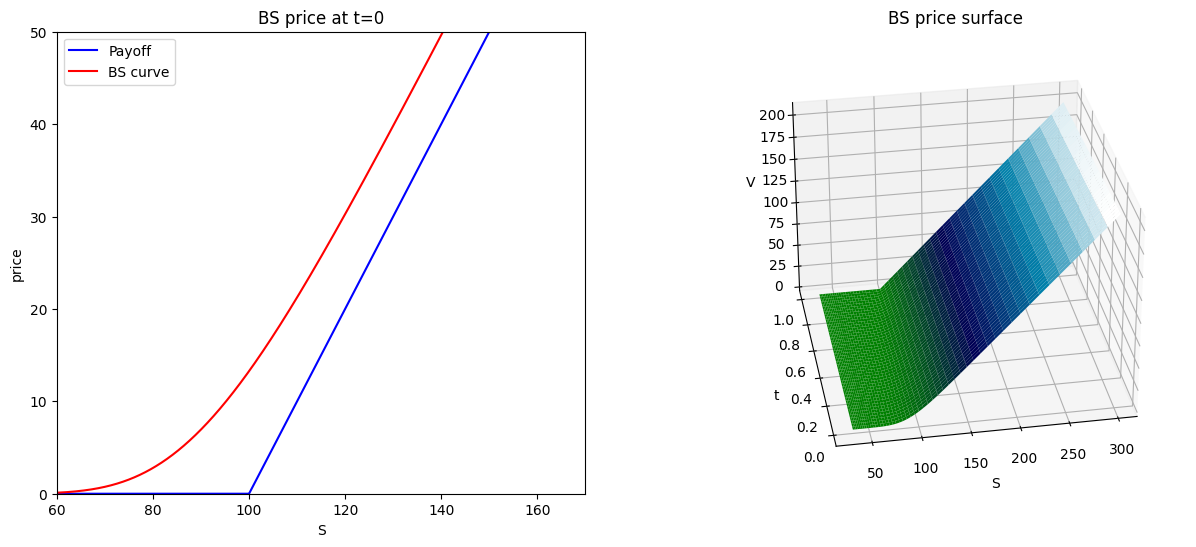

In [9]:
S = np.exp(x) # stock price
fig = plt.figure(figsize=(15, 6)) 
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="3d")

ax1.plot(S, Payoff, color="blue", label="Payoff")
ax1.plot(S, V[:, 0], color="red", label="BS curve")
ax1.set_xlim(60, 170)
ax1.set_ylim(0, 50)
ax1.set_xlabel("S")
ax1.set_ylabel("price")
ax1.legend(loc="upper left")
ax1.set_title("BS price at t=0")

X, Y = np.meshgrid(T, S)
ax2.plot_surface(Y, X, V, cmap=cm.ocean)
ax2.set_title("BS price surface")
ax2.set_xlabel("S")
ax2.set_ylabel("t")
ax2.set_zlabel("V")
ax2.view_init(30, -100)  # this function rotates the 3d plot
plt.show()

In the BS_pricer class there are more methods implemented.

In [10]:
from FMNM.Parameters import Option_param
from FMNM.Processes import Diffusion_process
from FMNM.BS_pricer import BS_pricer

# Creates the object with the parameters of the option
opt_param = Option_param(S0=100, K=100, T=1, exercise="European", payoff="call")

# Creates the object with the parameters of the process
diff_param = Diffusion_process(r=0.1, sig=0.2)

# Creates the object of the pricer
BS = BS_pricer(opt_param, diff_param)

ModuleNotFoundError: No module named 'FMNM'

In [11]:
print("Price: {0:.6f} Time: {1:.6f}".format(*BS.PDE_price((5000, 4000), Time=True, solver="splu")))
print("Price: {0:.6f} Time: {1:.6f}".format(*BS.PDE_price((5000, 4000), Time=True, solver="Thomas")))
print("Price: {0:.6f} Time: {1:.6f}".format(*BS.PDE_price((5000, 4000), Time=True, solver="spsolve")))
print("Price: {0:.6f} Time: {1:.6f}".format(*BS.PDE_price((5000, 4000), Time=True, solver="SOR")))

Price: 13.269418 Time: 1.735343
Price: 13.269418 Time: 2.081096
Price: 13.269418 Time: 14.749816
Price: 13.269418 Time: 49.727040


Thomas and SPLU are much faster.

price:  3.753265403553101


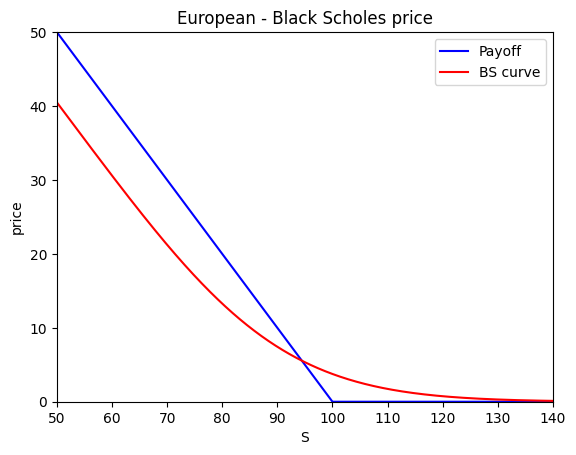

In [12]:
put_param = Option_param(S0=100, K=100, T=1, exercise="European", payoff="put")
# Creates the object of the put pricer
put = BS_pricer(put_param, diff_param)
print("price: ", put.PDE_price((5000, 4000)))
put.plot(axis=[50, 140, 0, 50])